# Generating Fake realistic candidates
## GPU support

In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import numpy as np
import os

from vip_hci.fits import open_fits

from plottools import create_circular_mask 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import gpu.fake_comp as tfnegfc


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2023-05-03 14:06:47.389081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 14:06:48.172188: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-03 14:06:48.172252: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-03 14:06:48.172258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Opening data

In [35]:
root = './data/DHTau/'

cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 1 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 80, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (2, 3, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


### Generating realistic sample 

[0.01911649852991104, 0.20663172006607056]


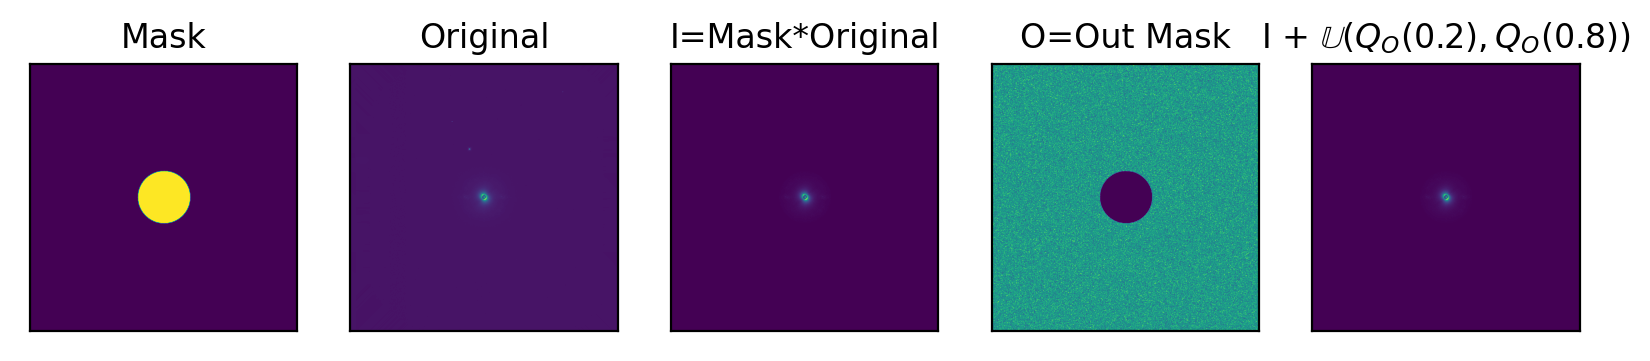

In [36]:
template = cube[lambda_ch]
nframes, height, width = template.shape
xc, yc = height//2, width//2

mask = create_circular_mask(h=height, w=width, center=(xc, yc), radius=100)
mask = np.tile(mask[None, ...], [nframes, 1,1])

in_masked  = template*mask
out_masked = template*(1.-mask)

out_20 = np.quantile(out_masked, .20)
out_80 = np.quantile(out_masked, .80)
print(f'[{out_20}, {out_80}]')
filler = np.random.uniform(out_20, out_80, [nframes, height, width])
filler_matrix = np.zeros_like(out_masked)+filler*(1.-mask)

new_template = in_masked + filler_matrix

fig, axes = plt.subplots(1, 5, figsize=(10,10), sharex=True, sharey=True, dpi=200)
axes = axes.flatten()

axes[0].imshow(mask[0])
axes[0].set_title('Mask')
axes[1].imshow(template[0])
axes[1].set_title('Original')
axes[2].imshow(in_masked[0])
axes[2].set_title('I=Mask*Original')
axes[3].imshow(filler_matrix[0])
axes[3].set_title('O=Out Mask')
axes[4].imshow(new_template[0])
axes[4].set_title(r'I + $\mathbb{U}(Q_{O}(0.2), Q_{O}(0.8))$')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [37]:
new_template.shape

(80, 1024, 1024)

### Normalizing PSF

In [38]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])

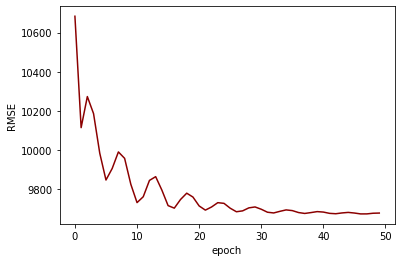

In [39]:
plt.plot(results['history'], color='darkred')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.show()

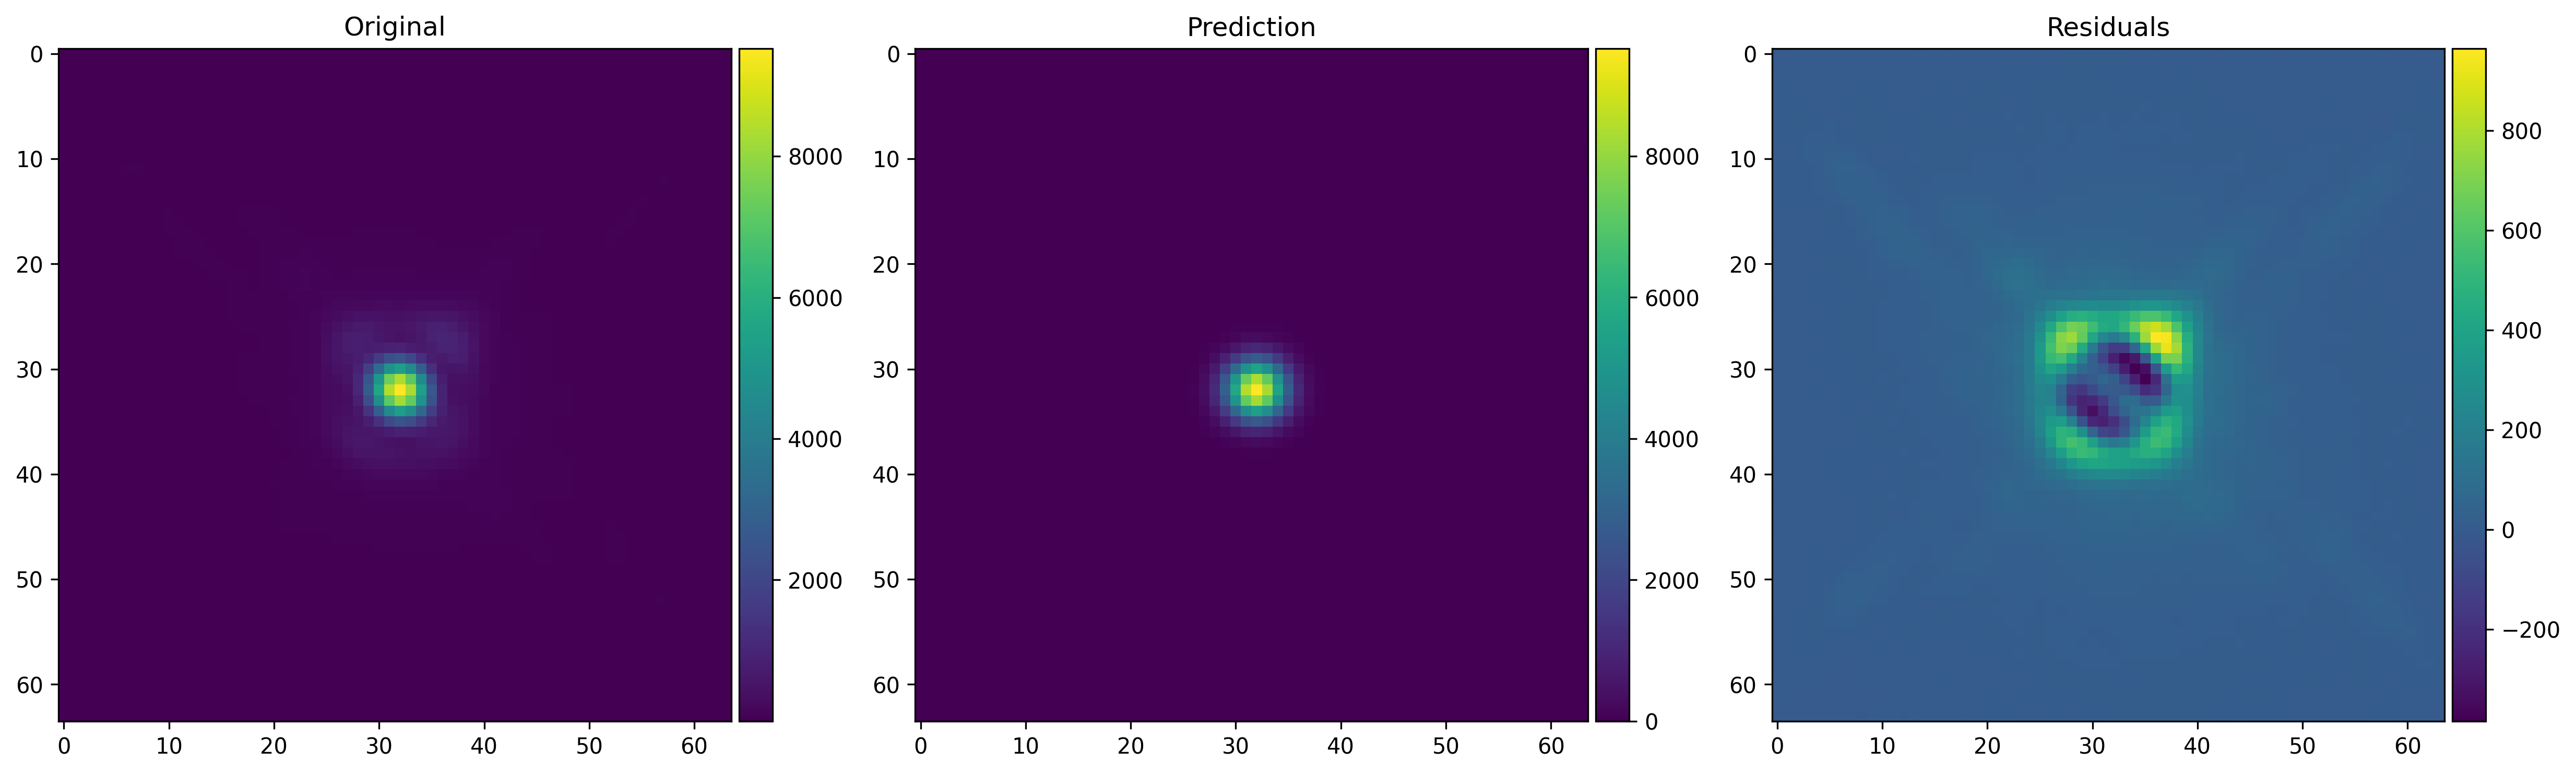

In [40]:
indices   = tf.cast(tf.where(psf[lambda_ch, psf_pos]), tf.float32)
y_pred = tfnegfc.gauss_model(indices, results['mean'], results['scale'], results['amplitude'])
y_pred_im = tf.reshape(y_pred, [psf.shape[-2], psf.shape[-1]])

fig, axes = plt.subplots(1, 3, figsize=(20,20), dpi=300)
im1 = axes[0].imshow(psf[lambda_ch, psf_pos])
axes[0].set_title('Original')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = axes[1].imshow(y_pred_im)
axes[1].set_title('Prediction')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

im3 = axes[2].imshow(psf[lambda_ch, psf_pos]-y_pred_im)
axes[2].set_title('Residuals')
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

plt.show()

In [41]:
fwhm_sphere  = tf.reduce_mean(results['fwhm'])

In [42]:
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)

In [43]:
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

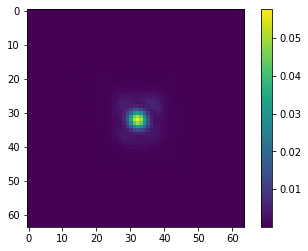

In [44]:
plt.show()
plt.imshow(normalized_psf[0])
plt.colorbar()

### Injecting fake companion

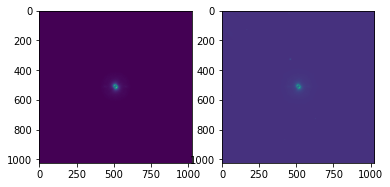

In [45]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(new_template[0])
im = axes[1].imshow(cube[0, 0])

In [46]:
new_template = np.array(new_template, dtype='float32')

In [47]:
new_template[0].shape, normalized_psf[0].shape


((1024, 1024), TensorShape([64, 64]))

In [48]:
patch = tfnegfc.create_patch(new_template[0], normalized_psf[0])

x_pos = 300.
y_pos = 400.
flux  = 5.4

inyected =  tfnegfc.inject_fake(x_pos, y_pos, flux, cube[0], patch, rot_ang)

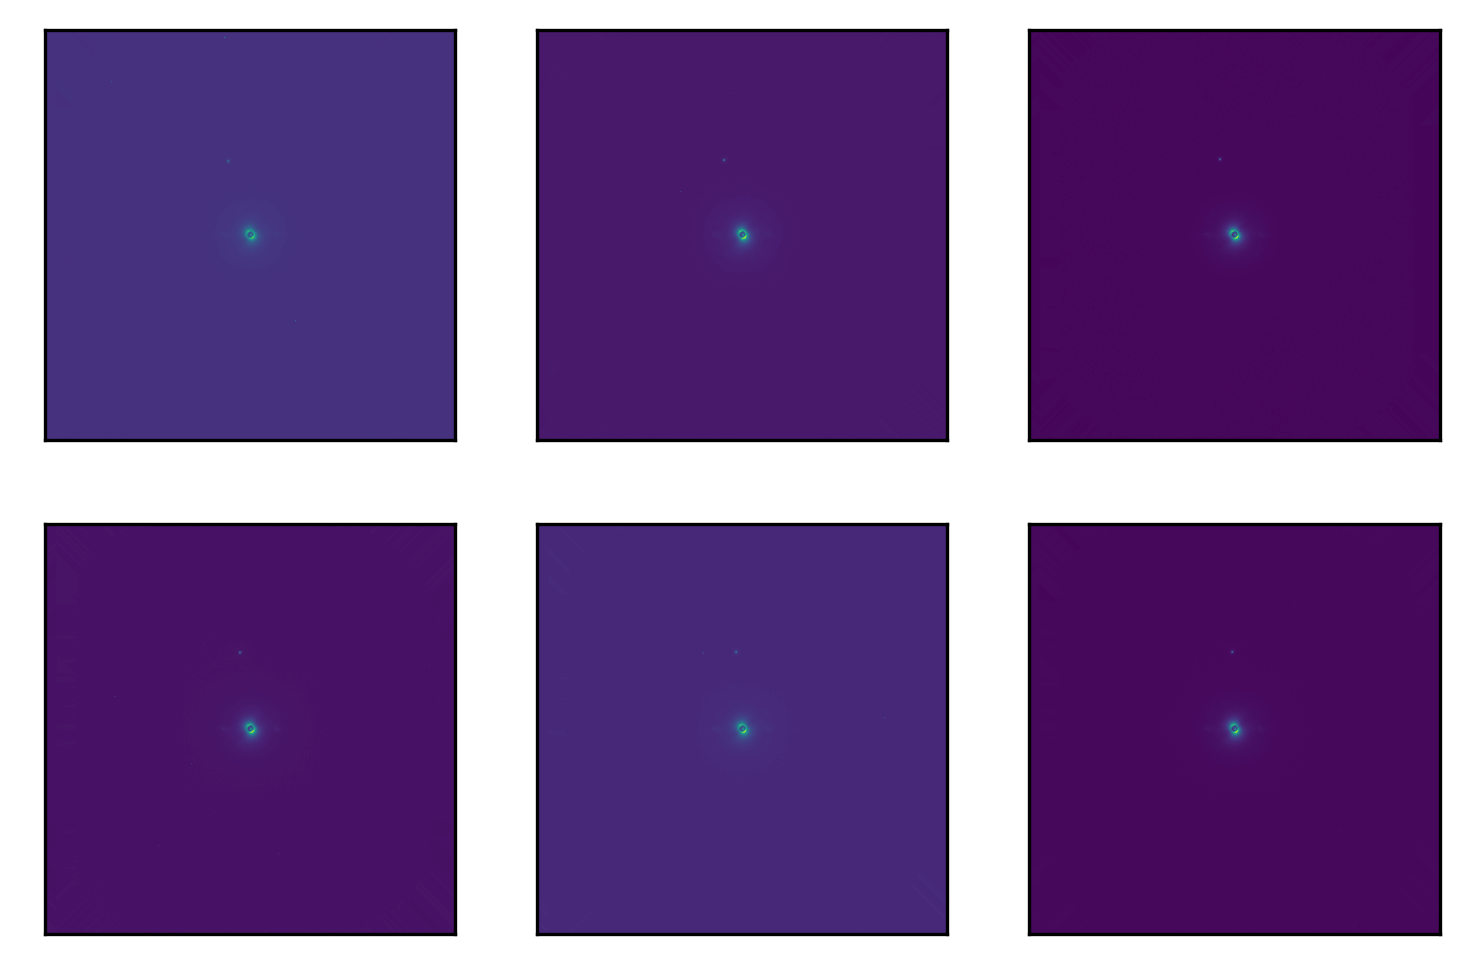

In [49]:
fig, axes = plt.subplots(2, 3, dpi=300)
axes = axes.flatten()
for i, x in enumerate(range(0, len(inyected), 10)):
    try:
        axes[i].imshow(inyected[x])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    except:
        break
#     fig.savefig(f'./figures/fake_data/{i}.png', format='png')

In [55]:
inyected_ext = tf.expand_dims(inyected, 0)
inyected_ext = tf.tile(inyected_ext, [2, 1, 1, 1])
inyected_ext.shape

TensorShape([2, 80, 1024, 1024])

In [59]:
from astropy.io import fits
import os
data_folder =  './data/DHTau_fake'
os.makedirs(data_folder, exist_ok=True)
hdu = fits.PrimaryHDU(inyected_ext)
hdu.writeto('./data/DHTau_fake/center_im.fits', overwrite=True)

In [60]:
import shutil 

shutil.copy(psf_route, os.path.join(data_folder, 'median_unsat.fits'))
shutil.copy(ra_route, os.path.join(data_folder, 'rotnth.fits'))

'./data/DHTau_fake/rotnth.fits'